<a href="https://colab.research.google.com/github/shravankumargulvadi/Assignment-6/blob/master/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time


import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.regularizers import l2
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D 
from keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D,Input, Concatenate,SeparableConv2D,DepthwiseConv2D


% matplotlib inline
np.random.seed(2017) 

Using TensorFlow backend.


In [2]:
# load train and test data
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

# number of train samples , img_depth, img_height, img_width
num_train, img_channels, img_rows, img_cols =  train_features.shape

# number of test samples
num_test, _, _, _ =  test_features.shape

# number of classes
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 10s 0us/step


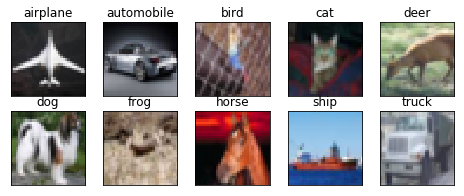

In [3]:
# define individual class names
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# plt each class image
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)
  
def scheduler(epoch, lr):
    return round(0.003 * 1/(1 + 0.319 * epoch), 10)

In [0]:
# pixel normalization
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Model definition

In [7]:


# input layer
input_layer = Input(shape=(32,32,3))

#Normal convolution layer
before_gc = Convolution2D(16, 3,3,border_mode='same', input_shape=(32, 32, 3))(input_layer) #RF:3
before_gc = BatchNormalization()(before_gc)
before_gc = Activation('relu')(before_gc)
before_gc = Dropout(0.1)(before_gc)

# Spatially separable convolution

sep_conv = Convolution2D(32, 3,1,border_mode='same')(input_layer) #RF:3
sep_conv = Convolution2D(32, 1,3,border_mode='same')(sep_conv)  #RF: 3
sep_conv = BatchNormalization()(sep_conv)
sep_conv = Activation('relu')(sep_conv)
sep_conv = Dropout(0.1)(sep_conv)

# Depthwise separable covolution
dep_conv = SeparableConv2D(32, 3,3,border_mode='same')(input_layer) #RF:3
dep_conv = BatchNormalization()(dep_conv)
dep_conv = Activation('relu')(dep_conv)
dep_conv = Dropout(0.1)(dep_conv)

##

before_gc_comp = Convolution2D(32, 3,3, border_mode='same')(before_gc) #RF: 5
before_gc_comp = BatchNormalization()(before_gc_comp)
before_gc_comp = Activation('relu')(before_gc_comp)
before_gc_comp = Dropout(0.1)(before_gc_comp)

before_gc_comp = Convolution2D(16, 1,1, border_mode='same')(before_gc) #RF: 5
before_gc_comp = BatchNormalization()(before_gc_comp)
before_gc_comp = Activation('relu')(before_gc_comp)
before_gc_comp = Dropout(0.1)(before_gc_comp)

# Group Convolution 1
## Depthwise 3x3
gc1_3 = SeparableConv2D(32, 3,3,  border_mode='same')(before_gc_comp) #RF:7
gc1_3 = BatchNormalization()(gc1_3)
gc1_3 = Activation('relu')(gc1_3)
gc1_3 = Dropout(0.1)(gc1_3)

## Depthwise 5x5
gc1_5 = SeparableConv2D(32, 5,5,  border_mode='same')(before_gc_comp) #RF:9
gc1_5 = BatchNormalization()(gc1_5)
gc1_5 = Activation('relu')(gc1_5)
gc1_5 = Dropout(0.1)(gc1_5)

#Merging
gc1_con = Concatenate(axis=-1)([gc1_3, gc1_5]) #RF=(7,9)
gc1_output = Convolution2D(32, 1,1, border_mode='same')(gc1_con)
gc1_output = BatchNormalization()(gc1_output)
gc1_output = Activation('relu')(gc1_output)
gc1_output = Dropout(0.1)(gc1_output)

# Group Convolution 2
# normal conv
gc2_3 = Convolution2D(32, 3,3,  border_mode='same')(gc1_output) #RF:(9, 11)
gc2_3 = BatchNormalization()(gc2_3)
gc2_3 = Activation('relu')(gc2_3)
gc2_3 = Dropout(0.1)(gc2_3)

# dilated conv
gc2_3d = Convolution2D(32, 3,3,  border_mode='same', dilation_rate=2)(gc1_output) #RF:(13,15)
gc2_3d = BatchNormalization()(gc2_3d)
gc2_3d = Activation('relu')(gc2_3d)
gc2_3d = Dropout(0.1)(gc2_3d)

# Merging 
gc2_con = Concatenate(axis=-1)([gc2_3, gc2_3d]) #RF: (9,11,13,15)
gc2_output = Convolution2D(32, 1,1, border_mode='same')(gc2_con) #RF: (9,11,13,15)
gc2_output = BatchNormalization()(gc2_output)
gc2_output = Activation('relu')(gc2_output)
gc2_output = Dropout(0.1)(gc2_output)

# Merging groupwise, space separable and depthwise separable Convolutions
input_conc = Concatenate(axis=-1)([sep_conv, dep_conv, gc2_output])
                                   
                                   
after_gc = MaxPooling2D(2)(input_conc) #RF: (3,5,18, 22, 26, 30)
after_gc = Convolution2D(32, 1,1, border_mode='same')(after_gc)
after_gc = BatchNormalization()(after_gc)
after_gc = Activation('relu')(after_gc)
after_gc = Convolution2D(32, (3,3), border_mode='same')(after_gc) #RF: (5,7,20, 24, 28, 32)
after_gc = BatchNormalization()(after_gc)
after_gc = Activation('relu')(after_gc)
after_gc = Dropout(0.1)(after_gc)

after_gc = Convolution2D(32, (3,3), border_mode='same')(after_gc) #RF: (7,9,22, 26, 30, 34)
after_gc = BatchNormalization()(after_gc)
after_gc = Activation('relu')(after_gc)
after_gc = Dropout(0.1)(after_gc)

after_gc = Convolution2D(32, (3,3), border_mode='same')(after_gc) #RF: (9,11,24, 28, 32, 36)
after_gc = BatchNormalization()(after_gc)
after_gc = Activation('relu')(after_gc)
after_gc = Dropout(0.1)(after_gc)

after_gc = Convolution2D(10, (1,1), border_mode='same')(after_gc) #RF: (11,13,24, 28, 32, 36)

# global average pooling
gap = GlobalAveragePooling2D()(after_gc)

logits = Activation('softmax')(gap)

model = Model(input_layer, logits)
model.summary()

# # Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0621 17:43:10.801607 140277025990528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 17:43:10.839134 140277025990528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
W0621 17:43:10.850063 140277025990528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0621 17:43:10.886489 140277025990528 deprecation_wrapper

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
  3/781 [..............................] - ETA: 42s - loss: 1.9069 - acc: 0.2812

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=781, epochs=50)`
  from ipykernel import kernelapp as app


781/781 [==============================] - 31s 40ms/step - loss: 1.3544 - acc: 0.5052 - val_loss: 1.5306 - val_acc: 0.4424
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
781/781 [==============================] - 31s 40ms/step - loss: 1.0034 - acc: 0.6389 - val_loss: 1.2908 - val_acc: 0.5463
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
781/781 [==============================] - 31s 40ms/step - loss: 0.8828 - acc: 0.6848 - val_loss: 1.8204 - val_acc: 0.4371
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
781/781 [==============================] - 31s 40ms/step - loss: 0.8134 - acc: 0.7101 - val_loss: 1.1548 - val_acc: 0.5819
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
781/781 [==============================] - 32s 40ms/step - loss: 0.7682 - acc: 0.7293 - val_loss: 1.1219 - val_acc: 0.6241
Epoch 6/50

Epoch 00006: LearningRateSche

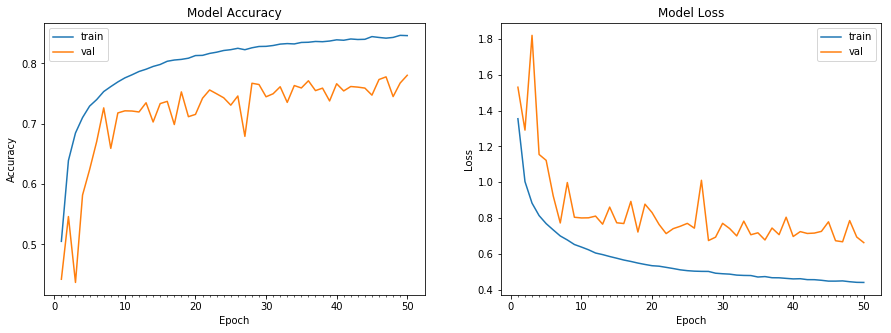

Accuracy on test data is: 78.04


In [9]:
# train the model using some augmentation methods
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

def scheduler(epoch, lr):
    return round(0.003 * 1/(1 + 0.319 * epoch), 10)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 64),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1,
                                 callbacks = [LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))